# Implementación de un control PI difuso

## Integrantes

- Esteban Padilla Cerdio A01703068

- Andrea González Arredondo A01351820         

- Naomi Estefanía Nieto Vega A01706095

- Karen Cebreros López A01704254

- Aranza Leal Aguirre A01751706

#### <b>Profesor</b>

Francisco Javier Navarro Barrón

#### <b>Fecha de entrega </b>

Miércoles 24 de mayo de 2023

## Evaluación

Esta actividad se evaluará de acuerdo a los siguientes criterios:
- El caso de aplicación (benchmark) está correctamente planteado.
- El controlador PI difuso es totalmente funcional y regula la respuesta a la referencia dada.
- Se reporta el desempeño del controlador con alguna métrica.
- El reporte contiene todos los puntos especificados.
- El contenido del reporte tiene una secuencia lógica.
- El contenido del reporte es claro y conciso.
- El análisis de la información y las conclusiones son relevantes.


## Resumen

 A lo largo de este reporte, se implementará un controlador difuso PI para controlar la salida en función de una señal de referencia. Se generarán las tablas con casos según el error y la tasa de cambio, se diseñará el controlador difuso utilizando Scikit Fuzzy, y se evaluará su desempeño utilizando una métrica como el RMSE. Se asumirán ganancias con valor = 1 y se justificarán posibles cambios realizados respecto al controlador visto en clase. El objetivo es lograr un controlador efectivo que se ajuste al valor de referencia establecido.

 ## I. Introducción

En esta actividad, se llevará a cabo la implementación de un controlador difuso PI para controlar la velocidad angular de un motor DC para el robot Puzzlebot, de Manchester Robotics, en función de la señal de referencia indicada por los encoders. El propósito principal será diseñar un controlador que pueda ajustarse a un valor de referencia específico, utilizando el enfoque difuso para modelar y controlar el sistema.

<img width="500" src="https://manchester-robotics.com/wp-content/uploads/puzzle-3-edited-1024x1024.jpg">

## II. Antecedentes

En un controlador PI clásico tenemos que ajustar los parámetros de forma analítica, es decir,  a través de diferentes modelos matemáticos como por ejemplo el método Ziegler-Nichols. Y es justo en los parámetros donde radica la diferencia entre un controlador clásico y uno difuso, pues en el controlador difuso, se nos permite tener en consideración la incertidumbre y las impresiciones. En lugar de utilizar métodos matemáticos, establece reglas lingüísticas que describen el comportamiento del sistema. Además, el controlador difuso emplea la etapa de fuzzificación para poder convertir las entradas y el error de control, en valores lingüísticos, para después realizar la defuzzificación para así obtener la señal de control numérica.

## III. Desarrollo

### Obtención de rangos de variables

Para el diseño de nuestro controlador PI, decidimos realizar un controlador con los valores de velocidad de los motores del Puzzlebot.
Para esto, primero se ejecutí el programa del robot simulado en sus capacidades máximas, con la finalidad de obtener la velocidad máxima de sus motores, la cual resultó ser de 20 rad/s. Por lo tanto, el rango de salidas de nuestro controlador sería <b>(-20, 20)</b>

<img width="750" src="https://drive.google.com/uc?export=view&id=1TCXe-E260HrL-Muh7rT8YpZ3kz36tze-">

Una vez obtenido este dato, sabemos que el error máximo posible será cuando la velocidad actual se encuentre en un extremo del rango, y la meta en el extremo opuesto. De esta manera, el valor del error se encontraría siempre en el rango <b>(-40, 40)</b>

A continuación, para sacar la derivada del error máxima, se ejecutó de nuevo el programa del robot simulado con los motores a toda velocidad. Se indicó una meta de 20 rad/s y se reunieron los datos del cambio en el error a través del tiempo. De esta manera se obtuvo la siguiente gráfica, donde se demuestra que la taza de cambio del error más grande posible es de 10.


<img width="750" src="https://drive.google.com/uc?export=view&id=1V2PurdjGbyRpoU7ejIcAxfOUkCQeQhDc">

Ya obtenida la información de la salida máxima, el error máximo y la taza de cambio máxima, fue posible comenzar con el diseño del modelo.

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
import numpy as np
from skfuzzy import control as ctrl
import skfuzzy as fuzz
# Define the input and output variables.

max_speed = 20
max_derivative = 10

error = ctrl.Antecedent(np.arange(-max_speed*2, max_speed*2 + 0.1, 0.1), "error")
derivative_of_error = ctrl.Antecedent(np.arange(-max_derivative, max_derivative + 0.1, 0.1), "derivada_error")
control_signal = ctrl.Consequent(np.arange(-max_speed, max_speed + 0.1, 0.1), "control_signal")



### Generación de funciones de pertenencia

Una vez definidos los rangos de nuestras variables lingüísticas, se realiza de forma automática las funciones de pertenencia. Para cada una de las variables se obtienen siete funciones, correspondientes a los siguientes valores:
- Negative big
- Negative medium
- Negative small
- Zero
- Positive small
- Positive medium
- Positive big

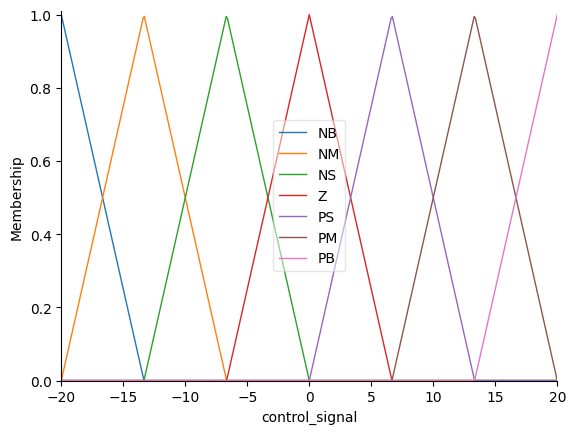

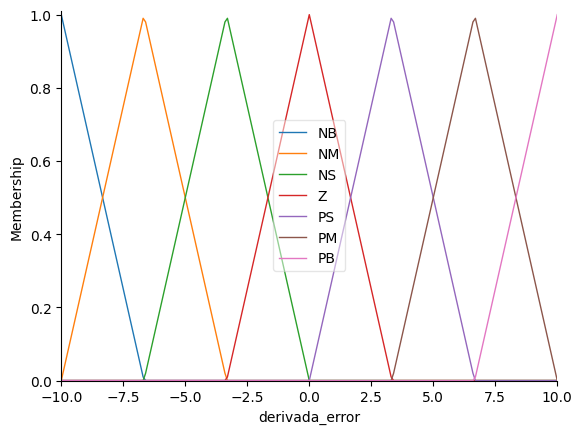

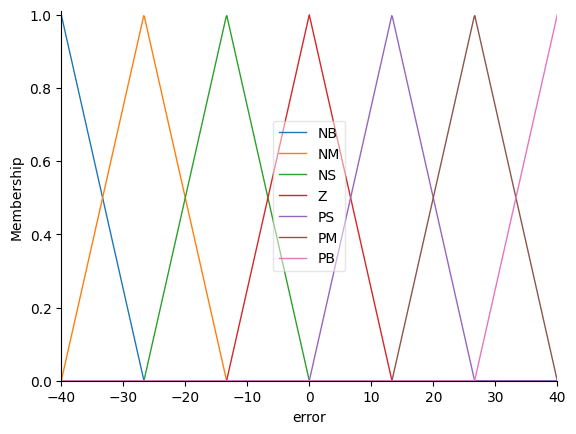

In [67]:
# Auto-membership function population is possible with .automf(3, 5, or 7)
antcds = ['NB', 'NM', 'NS', 'Z', 'PS', 'PM', 'PB']
error.automf(7, names=antcds)
derivative_of_error.automf(7, names=antcds)
control_signal.automf(7, names=antcds)

control_signal.view()
derivative_of_error.view()
error.view()


### Generación de reglas

Una vez obtenidas las funciones de pertenencia para las dos entradas y la única salida, se pueden generar las reglas correspondientes. Para esto, utilizaremos la siguiente tabla:

<img width="750" src="https://drive.google.com/uc?export=view&id=1J4cGPFFlBtw8zlRmWw2r5wfw3a0gjRoz">

El cuadro de reglas de PI difuso generalmente consta de dos componentes principales: los antecedentes (condiciones o entradas) y los consecuentes (acciones o salidas). Cada fila del cuadro representa una regla específica.
En este cuadro de reglas tenemos el error, representado por e(k) y nuestra tasa de cambio de(k), en nuestra primera columna, en respuesta a un error negativo grande y una tasa de cambio negativa grande, de igual forma se necesita una salida negativa grande para alcanzar el error, de nuestro controlador para que se minimice el error y así llegar a la salida deseada. De igual manera para cada una de las entradas existe una salida determinada, que va a permitir a nuestro controlador alcanzar la meta deseada. Mientras que cuando existe una tasa de error negativo y una tasa de cambio positiva, o viceversa, ya no se necesita ayuda del controlador, se convierte en una salida de 0 o nula. Es así como funciona el cuadro de reglas de PI difuso. 


In [68]:
# Create the fuzzy rules.
# Antecedent terms serving as inputs to this rule.
# Multiple terms may be combined using operators | (OR), & (AND), ~ (NOT), and parentheticals to group terms.
rules = []
cnsq=[['NB', 'NB', 'NB', 'NB', 'NM', 'NS', 'Z'],
     ['NB', 'NB', 'NM', 'NM', 'NS', 'Z', 'PS'],
     ['NB', 'NM', 'NS', 'NS', 'Z', 'PS', 'PM'],
     ['NM', 'NM', 'NS', 'Z', 'PS', 'PM', 'PM'],
     ['NM', 'NS', 'Z', 'PS', 'PS', 'PM', 'PB'],
     ['NS', 'Z', 'PS', 'PM', 'PM', 'PB', 'PB'],
     ['Z', 'PS', 'PM', 'PB', 'PB', 'PB', 'PB']]

for index_e, r_e in enumerate(antcds): # por cada antecedente en error
    for index_de, r_de in enumerate(antcds): # por cada antecedente en derivada error
        rules.append(ctrl.Rule(error[r_e] & derivative_of_error[r_de], control_signal[cnsq[index_e][index_de]]))

rules

[IF error[NB] AND derivada_error[NB] THEN control_signal[NB]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[NM] THEN control_signal[NB]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[NS] THEN control_signal[NB]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[Z] THEN control_signal[NB]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[PS] THEN control_signal[NM]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[PM] THEN control_signal[NS]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NB] AND derivada_error[PB] THEN control_signal[Z]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF error[NM] AND derivada_error[NB] THEN control_signal[NB]
 	AND aggregation function : fm

Ahora creamos el bloque de inferencia

In [69]:
# Create the inference block of the fuzzy controller.
fuzzy_controller = ctrl.ControlSystem(rules)
flc = ctrl.ControlSystemSimulation(fuzzy_controller) # The whole Fuzzy Inference system

### Benchmark

Ya que nuestro modelo ha sido diseñado, podemos realizar una prueba de sus capacidades. Para esto, generaremos una función step con la velocidad máxima previamente obtenida, y observaremos su comportamiento. Igualmente, podemos obtener un valor numérico del resultado a través del Error de Raíz Cuadrada Media.

Speed:  20
RMSE: 7.836550270613127


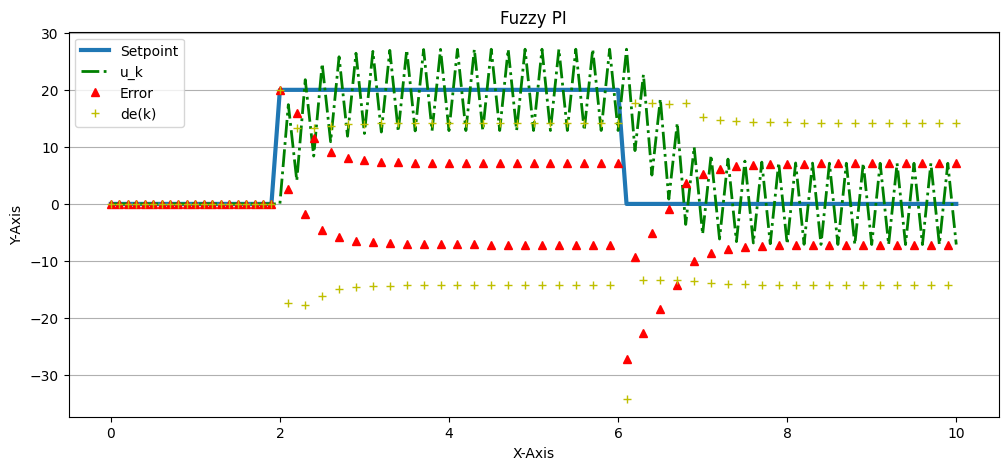

In [70]:
import matplotlib.pyplot as plt


def get_RMSE(real_values_list, predicted_value_list):
    return np.sqrt((np.square(np.subtract(real_values_list, predicted_value_list)).mean()))

xs = np.arange(0, 10.1, 0.1)

speed = 20

def stepfx(x): return speed if x >= 2.0 and x <= 6.0 else 0


ys = [stepfx(xi) for xi in xs]

# accion, error, tasa de cambio del error, error previo
u_k, e_k, de_k, prev_e_k = 0.0, 0.0, 0.0, 0.0
y_preds, errors, de, du = [], [], [], []
for xi in xs:
    ref = stepfx(xi)  # reference
    flc.inputs({'error': e_k, 'derivada_error': de_k})
    flc.compute()
    # Retrieve the output of the FLC component
    du_k = flc.output['control_signal']
    u_k = u_k + du_k  # take the feedback into account for new output
    e_k = ref - u_k  # current error
    de_k = e_k - prev_e_k  # rate of change of error
    prev_e_k = e_k  # update previous e_k

    y_preds.append(u_k)
    errors.append(e_k)
    de.append(de_k)
    du.append(du_k)

rmse = get_RMSE(ys, y_preds)
print("Speed: ", speed)
print('RMSE:', rmse)

plt.figure(figsize=(12, 5))
plt.gca().yaxis.grid(True)
plt.plot(xs, ys, linewidth=3, label='Setpoint')
plt.plot(xs, y_preds, 'g-.', linewidth=2, label='u_k')  # Fuzzy PI
plt.plot(xs, errors, 'r^', label='Error')
plt.plot(xs, de, 'y+', label='de(k)')

plt.title("Fuzzy PI")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.legend()
# Show the plot
plt.show()
  




Sin embargo, se puede observar a primera vista que el resultado no es óptimo, ya que existe una gran cantidad de oscilaciones en el sistema. Igualmente, se obtuvo un RMSE de 7.8, lo cual no es apropiado.

Para solucionar este problema, optamos por incrementar el rango de la taza de cambio en la generación de antecedentes, para suavizar de esta manera el efecto que ésta tiene en el sistema.

### Optimización del modelo

De forma manual, se fueron probando distintos valores para la taza de cambio máxima hasta llegar al 40, donde se concluyó que el resultado era lo más óptimo posible. Una vez obtenido este nuevo dato, se puede volver a diseñar el modelo, tomando en cuenta el nuevo rango de entradas.



In [71]:
max_speed = 20
max_derivative = 40

error = ctrl.Antecedent(
    np.arange(-max_speed*2, max_speed*2 + 0.1, 0.1), "error")
derivative_of_error = ctrl.Antecedent(
    np.arange(-max_derivative, max_derivative + 0.1, 0.1), "derivada_error")
control_signal = ctrl.Consequent(
    np.arange(-max_speed, max_speed + 0.1, 0.1), "control_signal")

# Auto-membership function population is possible with .automf(3, 5, or 7)
antcds = ['NB', 'NM', 'NS', 'Z', 'PS', 'PM', 'PB']
error.automf(7, names=antcds)
derivative_of_error.automf(7, names=antcds)
control_signal.automf(7, names=antcds)

# Create the fuzzy rules.
# Antecedent terms serving as inputs to this rule.
# Multiple terms may be combined using operators | (OR), & (AND), ~ (NOT), and parentheticals to group terms.
rules = []
cnsq=[['NB', 'NB', 'NB', 'NB', 'NM', 'NS', 'Z'],
     ['NB', 'NB', 'NM', 'NM', 'NS', 'Z', 'PS'],
     ['NB', 'NM', 'NS', 'NS', 'Z', 'PS', 'PM'],
     ['NM', 'NM', 'NS', 'Z', 'PS', 'PM', 'PM'],
     ['NM', 'NS', 'Z', 'PS', 'PS', 'PM', 'PB'],
     ['NS', 'Z', 'PS', 'PM', 'PM', 'PB', 'PB'],
     ['Z', 'PS', 'PM', 'PB', 'PB', 'PB', 'PB']]

for index_e, r_e in enumerate(antcds): # por cada antecedente en error
    for index_de, r_de in enumerate(antcds): # por cada antecedente en derivada error
        rules.append(ctrl.Rule(error[r_e] & derivative_of_error[r_de], control_signal[cnsq[index_e][index_de]]))

fuzzy_controller = ctrl.ControlSystem(rules)
flc = ctrl.ControlSystemSimulation(fuzzy_controller)


Con estos nuevos valores, se logró el siguiente resultado:

Speed:  20
RMSE: 3.59199103179563


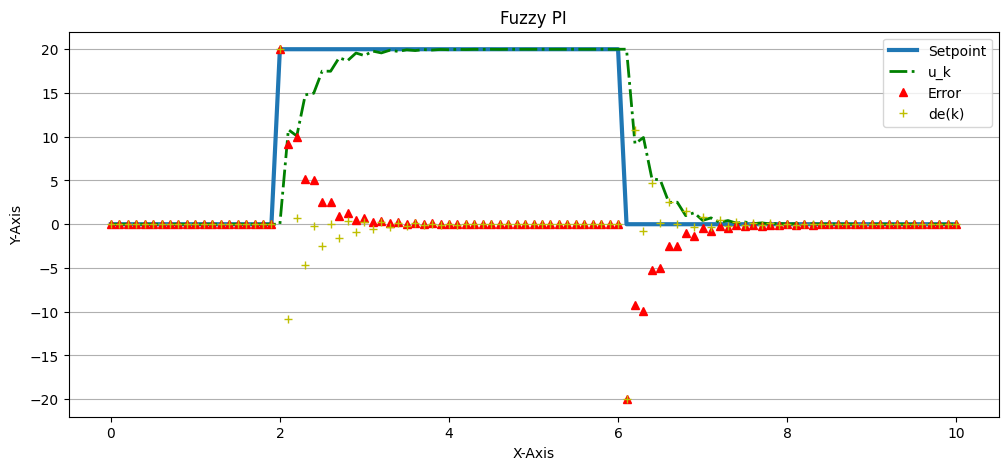

In [72]:
u_k, e_k, de_k, prev_e_k = 0.0, 0.0, 0.0, 0.0
y_preds, errors, de, du = [], [], [], []
for xi in xs:
    ref = stepfx(xi)  # reference
    flc.inputs({'error': e_k, 'derivada_error': de_k})
    flc.compute()
    # Retrieve the output of the FLC component
    du_k = flc.output['control_signal']
    u_k = u_k + du_k  # take the feedback into account for new output
    e_k = ref - u_k  # current error
    de_k = e_k - prev_e_k  # rate of change of error
    prev_e_k = e_k  # update previous e_k

    y_preds.append(u_k)
    errors.append(e_k)
    de.append(de_k)
    du.append(du_k)

rmse = get_RMSE(ys, y_preds)
print("Speed: ", speed)
print('RMSE:', rmse)

plt.figure(figsize=(12, 5))
plt.gca().yaxis.grid(True)
plt.plot(xs, ys, linewidth=3, label='Setpoint')
plt.plot(xs, y_preds, 'g-.', linewidth=2, label='u_k')  # Fuzzy PI
plt.plot(xs, errors, 'r^', label='Error')
plt.plot(xs, de, 'y+', label='de(k)')

plt.title("Fuzzy PI")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.legend()
# Show the plot
plt.show()


Tal y como podemos observar en la gráfica anterior, utilizando una derivada máxima de 40 se obtuvo un resultado mucho mejor, que cuenta con un error de 3.5, que corresponde solamente al tiempo que el sistema tarda en alcanzar la meta. 


### Casos de prueba

Finalmente, se continuó probando el modelo optimizado con varios valores para la entrada, con el objetivo de ver su comportamiento. Los valores probados, cuyos resultados se muestran a continuación, son:

- 0.1 rad/s
- 1 rad/s
- 10 rad/s
- 20 rad/s


Speed:  0.1
RMSE: 0.0185511936162433


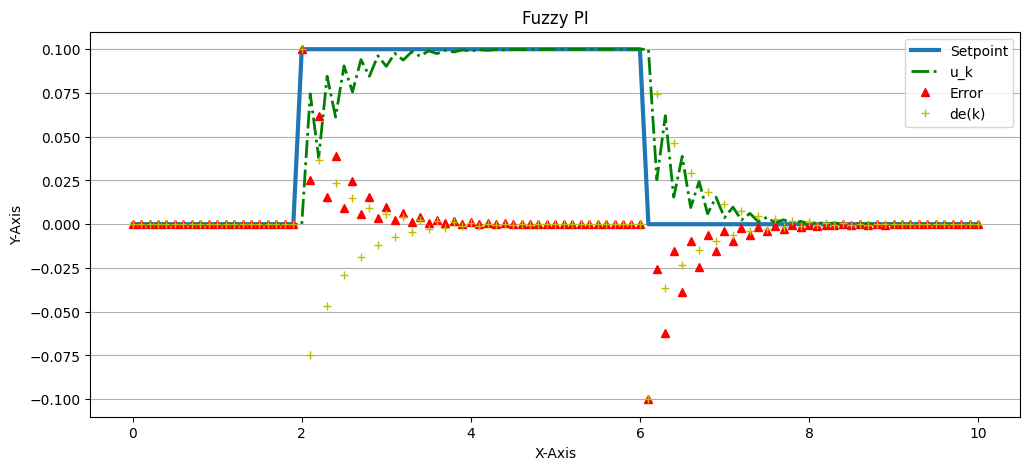

Speed:  1
RMSE: 0.18005549847748195


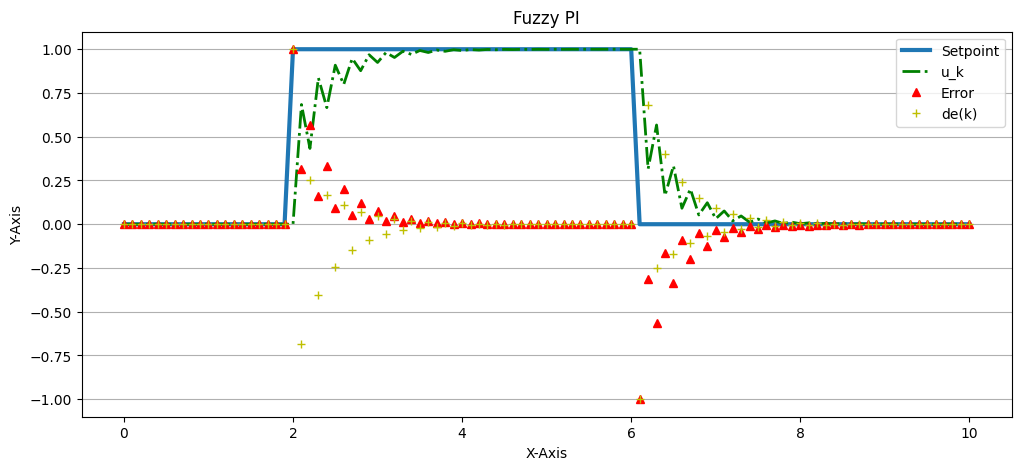

Speed:  10
RMSE: 1.8354895109740226


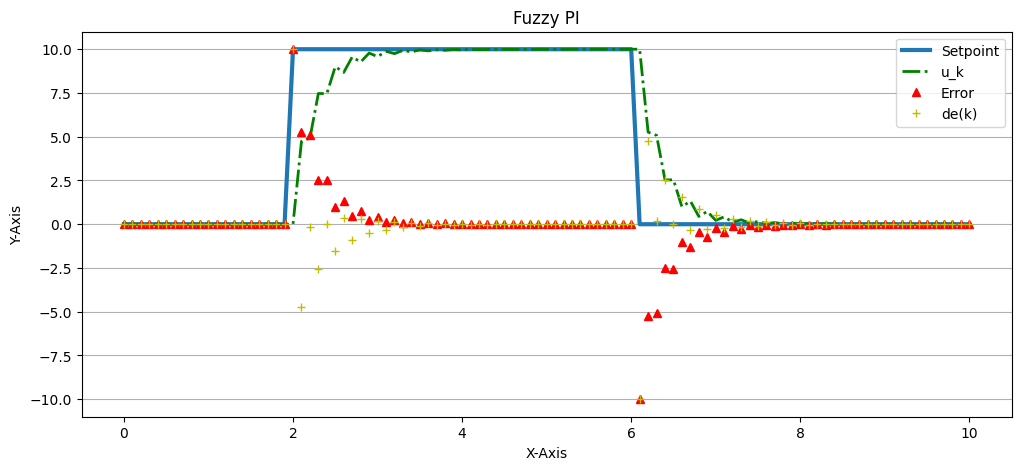

Speed:  20
RMSE: 3.59199103179563


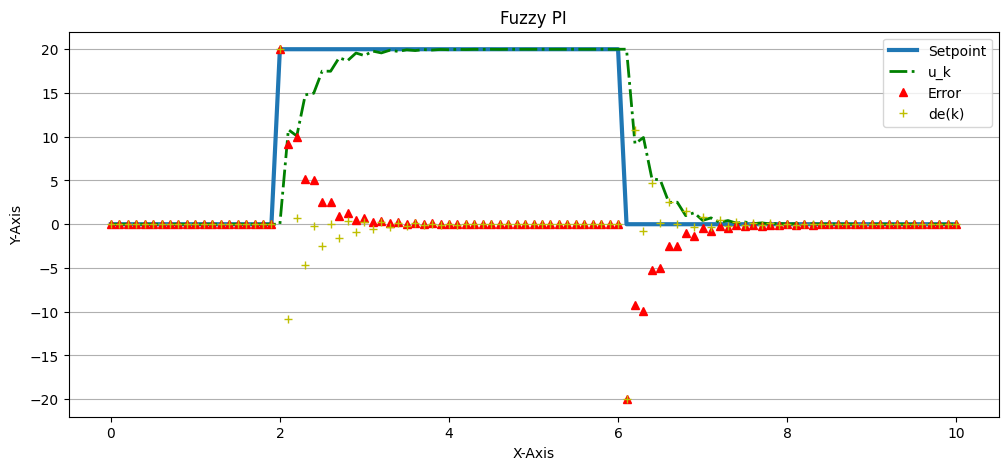

In [73]:
for speed in [0.1, 1, 10, 20]:
    
    def stepfx(x): return speed if x >= 2.0 and x <= 6.0 else 0
    ys = [stepfx(xi) for xi in xs]
 
    u_k, e_k, de_k, prev_e_k = 0.0, 0.0, 0.0, 0.0
    y_preds, errors, de, du = [], [], [], []
    for xi in xs:
        ref = stepfx(xi)  # reference
        flc.inputs({'error': e_k, 'derivada_error': de_k})
        flc.compute()
        # Retrieve the output of the FLC component
        du_k = flc.output['control_signal']
        u_k = u_k + du_k  # take the feedback into account for new output
        e_k = ref - u_k  # current error
        de_k = e_k - prev_e_k  # rate of change of error
        prev_e_k = e_k  # update previous e_k

        y_preds.append(u_k)
        errors.append(e_k)
        de.append(de_k)
        du.append(du_k)

    rmse = get_RMSE(ys, y_preds)
    print("Speed: ", speed)
    print('RMSE:', rmse)

    plt.figure(figsize=(12, 5))
    plt.gca().yaxis.grid(True)
    plt.plot(xs, ys, linewidth=3, label='Setpoint')
    plt.plot(xs, y_preds, 'g-.', linewidth=2, label='u_k')  # Fuzzy PI
    plt.plot(xs, errors, 'r^', label='Error')
    plt.plot(xs, de, 'y+', label='de(k)')

    plt.title("Fuzzy PI")
    plt.xlabel("X-Axis")
    plt.ylabel("Y-Axis")
    plt.legend()
    # Show the plot
    plt.show()


Como se puede apreciar, para todos los casos de prueba, el modelo se comporta de una manera apropiada. En el caso de velocidades bajas, existe una oscilación. Sin embargo, por las capacidades físicas del motor, alcanzar control de una velocidad baja es complicado de todas maneras, por lo que este resultado no es preocupante.

## Conclusión

En conclusión, esta actividad demostró que la implementación de un controlador difuso PI y su ajuste resultó ser un proceso relativamente sencillo y efectivo. En comparación con los controladores PID tradicionales, que requieren ajuste de dos parámetros, el controlador difuso PI simplificó el proceso al ajustar solo un parámetro, la taza de cambio máxima del error. A pesar de esta simplificación, el resultado obtenido fue altamente satisfactorio, logrando un control relativamente óptimo. Esto resalta la eficacia y la ventaja de utilizar controladores difusos en situaciones donde se requiere un ajuste preciso y rápido del sistema. Este enfoque difuso nos brindó adaptabilidad y robustez, ante las condiciones del sistema que en ocasiones pueden variar o ser imprecisas.

Además controladores difusos permiten el control de sistemas complejos al proporcionar un marco para manejar información imprecisa o incierta, y en base a ello se toman decisiones. Como se puede ver en la tabla utilizada durante el desarrollo de esta práctica, nos permite tener una representación lingüística de entradas, salidas y las distintas reglas.

Por lo tanto, esta práctica demostró ciertas ventajas de los controladores PI difusos sobre los clásicos, tales como la facilidad de optimización y la reducción de sistemas complejos e imprecisos a entradas y salidas fáciles de comprender. 


## Referencias

- Pospíchal, J. (1996). Fuzzy Sets and Fuzzy Logic: Theory and Applications. By George J. Klir and Bo Yuan. Prentice Hall: Upper Saddle River, NJ, 1995. 
- Kuncheva, L. I. (2001). Fuzzy Logic with Engineering Applications, Timothy J. Ross, (Ed.); McGraw Hill, New York, 1995, pp. 592, ISBN 0-07-053917-0. Neurocomputing, 41(1-4), 187. https://doi.org/10.1016/s0925-2312(01)00329-0
- skfuzzy 0.3 docs — skfuzzy v0.3 docs. (2023). Readthedocs.io. https://scikit-fuzzy.readthedocs.io/en/latest/
- (2019). Actividad: Implementación de un control PI difuso. Google Docs. https://docs.google.com/document/d/1d0b4FvmW-fSdStrlwftl7-YJLG1CF9_PzuuaxrN4_z4/edit
